In [1]:
import torch
import warnings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#local import
from radia.models.CNN import CNN
from radia.models.Hierarchical import Hierarchical
from radia.models.Weighted import Weighted
from radia.models.Weighted_hierarchical import Weighted_hierarchical
from radia.Metrics import Metrics
from radia.dataloaders.CXRLoader import CXRLoader
from radia.inference.inference import infer_loop,load_model
from radia import names,hierarchy

for key in hierarchy.keys():
    if key not in names :
        names.insert(0,key)

In [3]:
criterion = torch.nn.BCEWithLogitsLoss()
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
    warnings.warn("No gpu is available for the computation")

# ----- parsing arguments -------------------------------------
#start = torch.cuda.Event(enable_timing=True)
#end = torch.cuda.Event(enable_timing=True)
# ------loading test set --------------------------------------
#img_dir = os.environ["img_dir"]
img_dir=""
os.environ["DEBUG"]="True"
test_dataset = CXRLoader("Valid",img_dir, img_size=384,channels=3,datasets=["ChexPert"],prob=[0,]*5)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=24,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)


In [4]:
# ----------------loading model -------------------------------
models = [
        Weighted_hierarchical("convnext_large_384_in22ft1k", channels=3, num_classes=len(names), pretrained=False),

    ]
    # model =  torch.nn.parallel.DistributedDataParallel(model)

    # api = wandb.Api()
    # run = api.run(f"ccsmtl2/Chestxray/{args.run_id}")
    # run.file("models_weights/convnext_base/DistributedDataParallel.pt").download(replace=True)
weights = [
        "/data/model_weights/winter-vortex.pt",

    ]


models=load_model(weights=weights,models=models)

In [5]:

#start.record()
import time
start = time.time()
results = torch.zeros((len(test_dataset),len(names)))
for ex,model in enumerate(models) :
    model = model.to(device)
    running_loss, result = infer_loop(model=model, loader=test_loader, criterion=criterion, device=device)
    model = model.to("cpu")
    if ex==0 :
        results = result[1]
    else :
        results = torch.min(results,result[1])
#end.record()
end=time.time()
#torch.cuda.synchronize()
#print("time : ", start.elapsed_time(end))
print(end-start)
#plt.imshow(np.sum(heatmaps[0][0].detach().cpu().numpy(), axis=0))
#plt.savefig("heatmaps.png")

metric = Metrics(num_classes=len(names), names=names, threshold=np.zeros((len(names))) + 0.5)
metrics = metric.metrics()
metrics_results = {}
for key in metrics:
    pred = results.numpy()
    true = result[0].numpy().round(0)
    metric_result = metrics[key](true, pred)
    metrics_results[key] = metric_result

print(metrics_results)
i=0

100%|█████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it]


19.157286643981934
(200, 10)
{'auc': {'Enlarged Cardiomediastinum': 0.7541854636591478, 'Cardiomegaly': 0.7178878335594754, 'Pleural Effusion': 0.9053308823529411, 'Pneumothorax': 0.9192439862542956, 'Lung Opacity': 0.9289819376026273, 'Atelectasis': 0.8093866666666667, 'Pneumonia': 0.8619791666666666, 'Consolidation': 0.8738839285714286, 'Edema': 0.8357444243520192, 'No Finding': 0.8817418213969938, 'mean': 0.8488366111082263}, 'f1': {'Enlarged Cardiomediastinum': 0.7445255474452555, 'Cardiomegaly': 0.5697674418604651, 'Pleural Effusion': 0.7285714285714285, 'Pneumothorax': 0.14457831325301204, 'Lung Opacity': 0.8475836431226764, 'Atelectasis': 0.5783132530120482, 'Pneumonia': 0.09356725146198831, 'Consolidation': 0.3282051282051282, 'Edema': 0.3980582524271844, 'No Finding': 0.9304812834224598, 'mean': 0.5363651542781647}, 'recall': {'Enlarged Cardiomediastinum': 0.9714285714285714, 'Cardiomegaly': 0.7424242424242424, 'Pleural Effusion': 0.796875, 'Pneumothorax': 1.0, 'Lung Opacity':

100%|█████████████████████████████████████████| 192/192 [00:22<00:00,  8.71it/s]


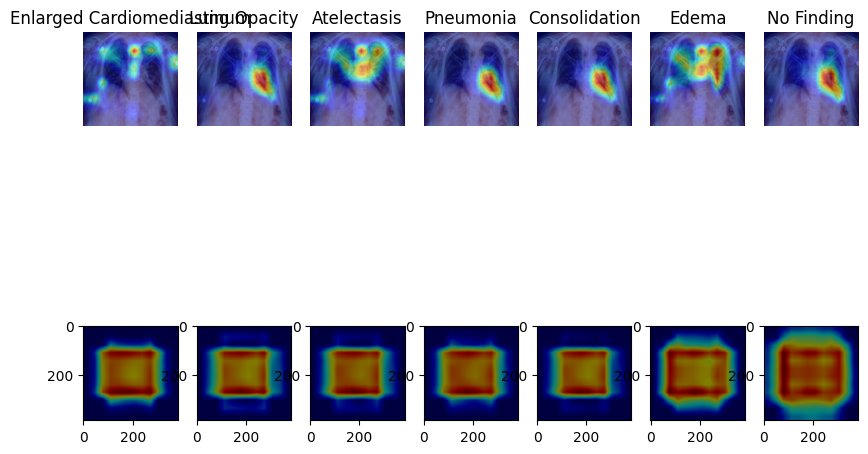

                               preds  ground-truth
Enlarged Cardiomediastinum  0.668675           1.0
Cardiomegaly                0.580691           0.0
Pleural Effusion            0.655053           1.0
Pneumothorax                0.601482           0.0
Lung Opacity                0.696773           1.0
Atelectasis                 0.722608           1.0
Pneumonia                   0.731055           0.0
Consolidation               0.729003           0.0
Edema                       0.675688           0.0
No Finding                  0.721228           1.0


100%|█████████████████████████████████████████| 192/192 [00:21<00:00,  8.81it/s]


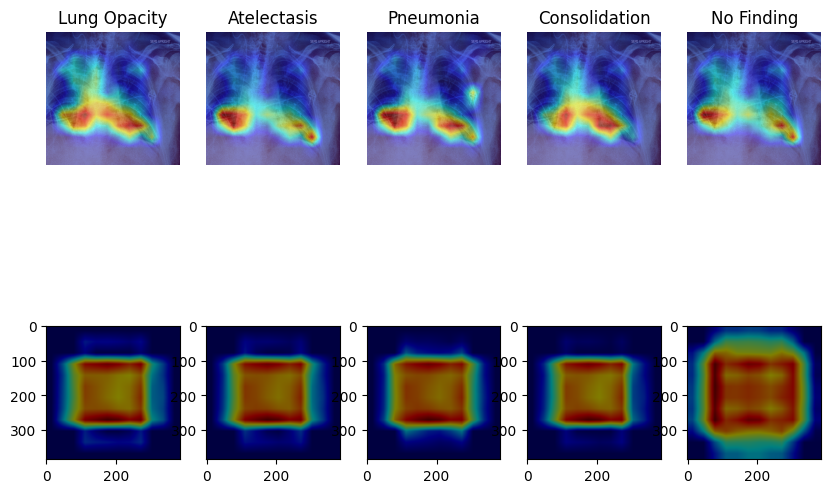

                               preds  ground-truth
Enlarged Cardiomediastinum  0.668162           1.0
Cardiomegaly                0.602094           1.0
Pleural Effusion            0.660641           0.0
Pneumothorax                0.663833           0.0
Lung Opacity                0.692393           1.0
Atelectasis                 0.725728           1.0
Pneumonia                   0.726334           0.0
Consolidation               0.727046           0.0
Edema                       0.648215           0.0
No Finding                  0.721143           1.0


100%|█████████████████████████████████████████| 192/192 [00:22<00:00,  8.69it/s]


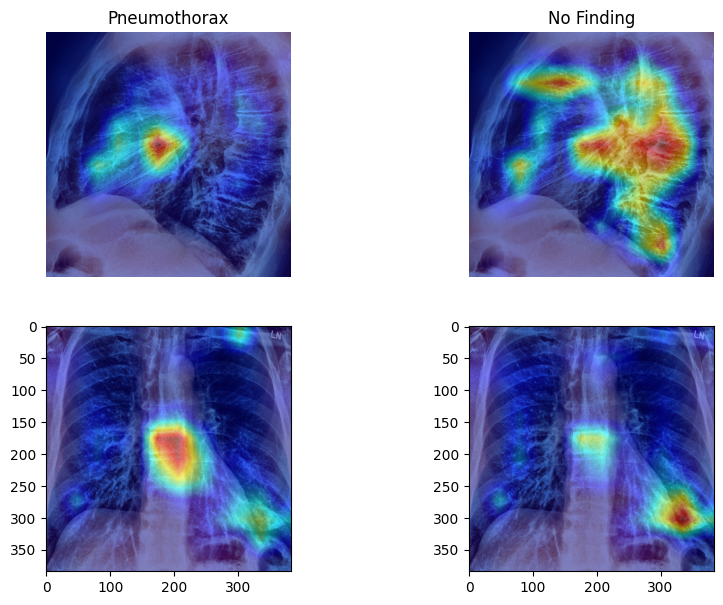

                               preds  ground-truth
Enlarged Cardiomediastinum  0.622685           0.0
Cardiomegaly                0.622013           0.0
Pleural Effusion            0.545078           0.0
Pneumothorax                0.690409           1.0
Lung Opacity                0.634382           1.0
Atelectasis                 0.611108           0.0
Pneumonia                   0.629689           0.0
Consolidation               0.629031           0.0
Edema                       0.595073           0.0
No Finding                  0.715995           1.0


100%|█████████████████████████████████████████| 192/192 [00:21<00:00,  8.76it/s]


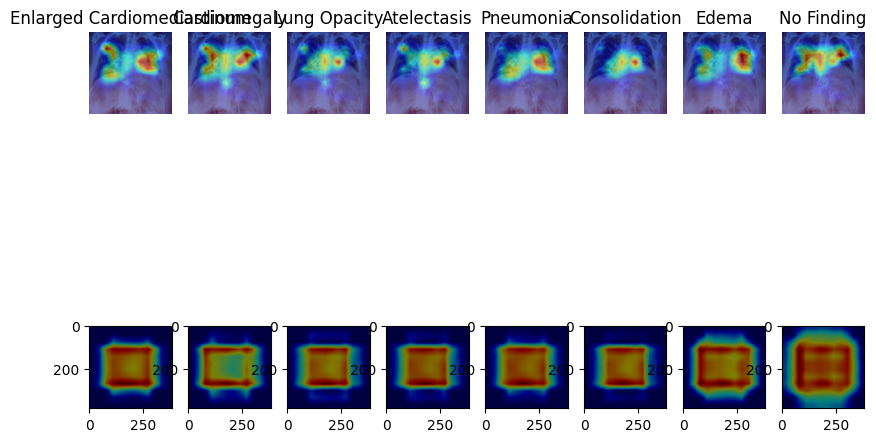

                               preds  ground-truth
Enlarged Cardiomediastinum  0.687423           1.0
Cardiomegaly                0.670149           1.0
Pleural Effusion            0.665442           1.0
Pneumothorax                0.581642           0.0
Lung Opacity                0.691497           1.0
Atelectasis                 0.718276           1.0
Pneumonia                   0.730532           1.0
Consolidation               0.727326           1.0
Edema                       0.693321           0.0
No Finding                  0.719093           1.0


100%|█████████████████████████████████████████| 192/192 [00:21<00:00,  8.87it/s]


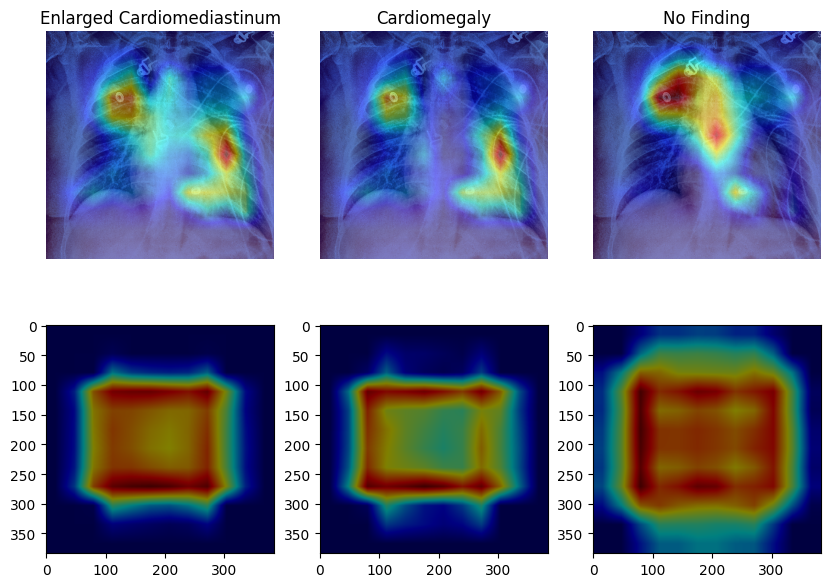

                               preds  ground-truth
Enlarged Cardiomediastinum  0.683764           1.0
Cardiomegaly                0.721365           1.0
Pleural Effusion            0.547403           0.0
Pneumothorax                0.550242           0.0
Lung Opacity                0.620658           0.0
Atelectasis                 0.621580           0.0
Pneumonia                   0.621431           0.0
Consolidation               0.620107           0.0
Edema                       0.620383           0.0
No Finding                  0.708067           1.0


100%|█████████████████████████████████████████| 192/192 [00:21<00:00,  8.86it/s]


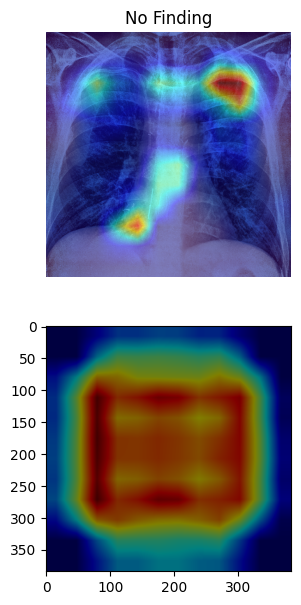

                               preds  ground-truth
Enlarged Cardiomediastinum  0.646421           0.0
Cardiomegaly                0.590872           0.0
Pleural Effusion            0.538140           0.0
Pneumothorax                0.586272           0.0
Lung Opacity                0.612528           0.0
Atelectasis                 0.619758           0.0
Pneumonia                   0.616685           0.0
Consolidation               0.613661           0.0
Edema                       0.622621           0.0
No Finding                  0.677167           1.0


In [7]:
"""
THIS SECTION IS TO HAVE A HEATMAP PER DISEASE


"""
#inputs,labels=test_dataset[i]
#Manually loading images
import cv2 as cv
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import FullGrad,EigenCAM,GradCAM,HiResCAM,GradCAMPlusPlus,ScoreCAM
from PIL import Image
import json
model = models[0] # only using 1 model, not an Ensemble
model = model.to(device)
cams=[
    #FullGrad(model,target_layers=[]), #crashes
    #EigenCAM(model,target_layers=[model.backbone.stages[-1 , #same as gradcam
    #GradCAM(model,target_layers=[model.backbone.stages[-1]]),
    #HiResCAM(model,target_layers=[model.backbone.stages[-1]]),
    ScoreCAM(model,target_layers=[model.backbone.stages[-1]],use_cuda=True),
]
cam=cams[-1]
setattr(cams[-1],"batch_size",8)
img_size=384

for i in range(4,10) :
    results= {}
    inputs,labels,idx = test_dataset[i]
    results["labels"] = labels.tolist()
    inputs = inputs[None,:,:,:]
    inputs = inputs.to(device,non_blocking=True)
    # forward + backward + optimize
    #model.hierarchical=True
    outputs = torch.sigmoid(model(inputs))
    results["pred"] = outputs.tolist()
    #model.hierarchical=False
    channels=3

    img0=inputs[0:1,0*channels : (0+1)*channels,:,:]

    img1=inputs[0:1,1*channels : (1+1)*channels,:,:]
    # create figure
    fig = plt.figure(figsize=(10, 7))

    img = test_dataset.read_img(i)
    channels=3
    img0_display=img[:,:,0:channels].astype(np.uint8)
    results["img0"] = img0_display.tolist()
    img1_display=img[:,:,channels:2*channels].astype(np.uint8)
    results["img1"] = img1_display.tolist()
    if channels ==1 :
        img0_display = cv.cvtColor(img0_display,cv.COLOR_GRAY2RGB)
        img1_display=cv.cvtColor(img1_display,cv.COLOR_GRAY2RGB)

    rows=2


    targets = [ClassifierOutputTarget(i) for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]
    targets_idx = [i for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]
    columns=len(targets)
    for ex,target in enumerate(targets,start=1) :
        with torch.no_grad() :
            heatmap0 = cam(img0.float(),targets=[target]).squeeze() * -255+255
            results[f"heatmap_0_{names[targets_idx[ex-1]]}"] = heatmap0.tolist()

            heatmap1 = cam(img1.float(),targets=[target]).squeeze() * -255+255
            results[f"heatmap_1_{names[targets_idx[ex-1]]}"] = heatmap1.tolist()

        #heatmap0 = np.where(heatmap0<0.9,0,heatmap0)
        #heatmap1 = np.where(heatmap0<0.9,0,heatmap1)
        fig.add_subplot(rows, columns, ex)
        heatmap0 = np.array(cv.applyColorMap(cv.cvtColor(heatmap0[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))


        heatmap0 = cv.addWeighted(heatmap0, 0.5, img0_display, 0.5, 0)
        results[f"combined_0_{names[targets_idx[ex-1]]}"] = heatmap0.tolist()
        plt.imshow(heatmap0.squeeze())
        plt.axis('off')
        plt.title(names[targets_idx[ex-1]])


        fig.add_subplot(rows, columns, len(targets)+ex)
        heatmap1 = np.array(cv.applyColorMap(cv.cvtColor(heatmap1[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))
        heatmap1 = cv.addWeighted(heatmap1, 0.5, img1_display, 0.5, 0)
        results[f"combined_1_{names[targets_idx[ex-1]]}"] = heatmap1.tolist()
        plt.imshow(heatmap1.squeeze())

    plt.savefig(f"heatmap_{i}_per_target")
    f = open(f"heatmap_{i}_per_target.json","w")
    json.dump(results,f)
    f.close()
    plt.show()
    # plt.imshow(img0_display)
    # plt.show()
    # plt.imshow(img1_display)
    # plt.show()
    #Image.fromarray(heatmap0).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_frontal.jpg")
    #Image.fromarray(heatmap1).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_lateral.jpg")


    #loss = criterion(outputs.squeeze(), labels)
    outputs = torch.sigmoid(outputs)

    data=pd.DataFrame([outputs.cpu().detach().numpy().squeeze(),labels.cpu().numpy().squeeze()],columns=names,index=["preds","ground-truth"])

    print(data.T)



In [ ]:
"""
THIS SECTION IS TO HAVE A HEATMAP PER METHOD


"""
#inputs,labels=test_dataset[i]
#Manually loading images
import cv2 as cv
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import FullGrad,EigenCAM,GradCAM,HiResCAM,GradCAMPlusPlus,ScoreCAM
from PIL import Image

model = models[0] # only using 1 model, not an Ensemble
model = model.to(device)
cams=[
    FullGrad(model,target_layers=[]), #crashes
    EigenCAM(model,target_layers=[model.backbone.stages[-1]]), #same as gradcam
    #GradCAM(model,target_layers=[model.backbone.stages[-1]]),
    #HiResCAM(model,target_layers=[model.backbone.stages[-1]]),
    ScoreCAM(model,target_layers=[model.backbone.stages[-1]],use_cuda=True),
]

setattr(cams[-1],"batch_size",64)
img_size=384
for i in range(0,10) :
    inputs,labels,idx = test_dataset[i]
    inputs = inputs[None,:,:,:]
    inputs = inputs.to(device,non_blocking=True)
    # forward + backward + optimize
    model.hierarchical=True
    outputs = model(inputs)
    #model.hierarchical=False
    channels=3

    img0=inputs[0:1,0*channels : (0+1)*channels,:,:]

    img1=inputs[0:1,1*channels : (1+1)*channels,:,:]
    # create figure
    fig = plt.figure(figsize=(10, 7))

    img = test_dataset.read_img(i)
    channels=3
    img0_display=img[:,:,0:channels].astype(np.uint8)

    img1_display=img[:,:,channels:2*channels].astype(np.uint8)
    if channels ==1 :
        img0_display = cv.cvtColor(img0_display,cv.COLOR_GRAY2RGB)
        img1_display=cv.cvtColor(img1_display,cv.COLOR_GRAY2RGB)

    rows=2


    targets = [ClassifierOutputTarget(i) for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]
    targets_idx = [i for i,output in enumerate(outputs.squeeze().cpu().tolist()) if output>0.7]

    for ex,cam in enumerate(cams,start=1) :
        heatmap0 = cam(img0.float(),targets=targets).squeeze() * -255+255

        heatmap1 = cam(img1.float(),targets=targets).squeeze() * -255+255


        #heatmap0 = np.where(heatmap0<0.9,0,heatmap0)
        #heatmap1 = np.where(heatmap0<0.9,0,heatmap1)
        fig.add_subplot(rows, columns, ex)
        heatmap0 = np.array(cv.applyColorMap(cv.cvtColor(heatmap0[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))


        heatmap0 = cv.addWeighted(heatmap0, 0.5, img0_display, 0.5, 0)

        plt.imshow(heatmap0.squeeze())
        plt.axis('off')



        fig.add_subplot(rows, columns, len(targets)+ex)
        heatmap1 = np.array(cv.applyColorMap(cv.cvtColor(heatmap1[:, :,None].astype(np.uint8), cv.COLOR_RGB2BGR),cv.COLORMAP_JET))
        heatmap1 = cv.addWeighted(heatmap1, 0.5, img1_display, 0.5, 0)
        plt.imshow(heatmap1.squeeze())
        plt.axis('off')

    plt.savefig(f"heatmap_{i}")

    plt.show()
    # plt.imshow(img0_display)
    # plt.show()
    # plt.imshow(img1_display)
    # plt.show()
    #Image.fromarray(heatmap0).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_frontal.jpg")
    #Image.fromarray(heatmap1).save("c:/Users/joeda/PycharmProjects/IA-MED_IMG/dataheatmap_lateral.jpg")


    #loss = criterion(outputs.squeeze(), labels)
    outputs = torch.sigmoid(outputs)

    data=pd.DataFrame([outputs.cpu().detach().numpy().squeeze(),labels.cpu().numpy().squeeze()],columns=names,index=["preds","ground-truth"])

    print(data.T)


